# Проверка гипотез в бизнесе
Компания крупного сервиса проката самокатов GoFast предоставила три датасета с данными о пользователях сервиса, их поездках за один год, а также стоимости услуг в подписках. Необходимо проанализировать демографию пользователей и особенности использования самокатов, а также определить возможную выгоду от распространения платной подписки на самокаты.

# Описание данных

Таблица с пользователями `users_go.csv`

- `user_id` — уникальный идентификатор пользователя.

- `name` — имя пользователя.

- `age` — возраст.

- `city` — город.

- `subscription_type` — тип подписки: `free`, `ultra`.

Таблица с поездками `rides_go.csv`

- `user_id` — уникальный идентификатор пользователя.

- `distance` — расстояние в метрах, которое пользователь проехал в текущей сессии.

- `duration` — продолжительность сессии в минутах, то есть время с того момента, как пользователь нажал кнопку «Начать поездку», до того, как он нажал кнопку «Завершить поездку».

- `date` — дата совершения поездки.

Таблица с подписками `subscriptions_go.csv`

- `subscription_type` — тип подписки.

- `minute_price` — стоимость одной минуты поездки по этой подписке.

- `start_ride_price` — стоимость начала поездки.

- `subscription_fee` — стоимость ежемесячного платежа.

---
## 1. Загрузка данных
Загрузим все необходимые данные и познакомимся с содержанием таблиц.

### 1.1 Импорт библиотеки pandas
Импортируем библиотеку pandas с сокращением `pd`.

In [1]:
import pandas as pd

### 1.2 Чтение данных
Cчитаем и сохраним в отдельные датафреймы три CSV-файла. 

In [2]:
df_users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
df_rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
df_subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

### 1.3 Печать первых строк
Выведем первые пять строк каждого датафрейма. Познакомимся с содержанием таблиц.

In [3]:

# display('df_users_go', df_users_go.head(5), 
#         'df_rides_go',df_rides_go.head(5),
#         'df_subscriptions_go', df_subscriptions_go.head(5))
display(df_users_go.head(5))
display(df_rides_go.head(5))
display(df_subscriptions_go.head(5))

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


### 1.4 Подсчёт строк
Определим количество строк в каждом из трёх датафреймов. Это поможет оценить объём данных и выявить аномалии, например слишком малое количество записей. Запишем три целых числа в одну строку через пробел.

In [4]:
# print('Количество записей:\n', 
#       len(df_users_go), '- df_users_go \n',
#       len(df_rides_go), '- df_rides_go \n', 
#       len(df_subscriptions_go), '- df_subscriptions_go')
print(len(df_users_go), len(df_rides_go), len(df_subscriptions_go))

1565 18068 2


---
## 2. Знакомство с данными и их предварительная подготовка

Убедимся в качестве предоставленных данных. Изучим структуру и устраним потенциальные проблемы в таблицах.

### 2.1 Определение типов данных
Для проверки корректности типов данных в датафрейме `df_rides_go` выведем типы данных каждой колонки стандартным атрибутом `dtypes`. 

In [5]:
df_rides_go.dtypes

user_id       int64
distance    float64
duration    float64
date         object
dtype: object

### 2.2 Преобразование формата даты
Приведём столбец `date` в датафрейме `df_rides_go` к типу даты pandas, используя метод `pd.to_datetime()`, изученный вами в одном из прошлых спринтов. 

In [6]:
df_rides_go['date'] = pd.to_datetime(df_rides_go['date'])
print(df_rides_go['date'].dtypes)

datetime64[ns]


### 2.3 Создание столбца с месяцем
На основе столбца `date` создадим новый столбец `month`, содержащий номер месяца. Это нужно для последующей группировки данных и анализа сезонных трендов.

In [7]:
df_rides_go['month'] = df_rides_go['date'].dt.month
df_rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### 2.4 Поиск дублей и пропусков
В датафрейме пользователей `df_users_go` определим количество пропусков и дубликатов. Ответ выведем в виде двух целых чисел, разделённых пробелом.

In [8]:
print(df_users_go.isna().sum().sum(), 
      df_users_go.duplicated().sum())
# df_users_go.info()

0 31


### 2.5 Заполнение пропусков и удаление дублей
При наличии пропущенных значений заполним их нулями, а все дубликаты удалим. 

In [9]:
df_users_go = df_users_go.drop_duplicates()

df_users_go.duplicated().sum()
# df_users_go[df_users_go['user_id']==829]


0

### 2.6 Округление длительности поездки
В датафрейме поездок `df_rides_go` округлим время поездки `duration` до целого числа стандартным методом `round()`. Затем приведём эту колонку к целочисленному типу `int`. Этот шаг затем поможет вам правильно рассчитать прибыль, так как плата взимается только за целое число минут.

In [10]:
# df_rides_go['duration'] = pd.to_numeric(round(df_rides_go['duration']), downcast='integer')
df_rides_go['duration'] = round(df_rides_go['duration']).astype('int64')
df_rides_go['duration']

0        26
1        16
2         6
3        19
4        26
         ..
18063    20
18064    21
18065    18
18066    17
18067    16
Name: duration, Length: 18068, dtype: int64

---
## 3. Исследовательский анализ данных (EDA)
Исследовательский анализ данных. Изучим и визуализируем информацию о географии и демографии сервиса, а также лучше поймём закономерности в дистанциях и длительности поездок.


### 3.1 Импорт библиотеки matplotlib
Импортируем библиотеку matplotlib.pyplot с сокращением `plt`.

In [11]:
# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt

### 3.2 Количество пользователей по городам.
Пользуясь данными из датафрейма `df_users_go`, изучим количество пользователей в каждом из городов. Создадим и выведеи на экран объект `pd.Series`, названный `users_by_city_count`, с одной колонкой `count` — суммарным количеством пользователей в каждом городе `city`, отсортированным по убыванию.

In [12]:
# users_by_city_count = df_users_go.groupby('city')['user_id'].count().rename('count').sort_values(ascending=False).reset_index()
users_by_city_count = df_users_go['city'].value_counts()
users_by_city_count

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

### 3.3 Количество пользователей подписки
Создадим и выведем на экран серию `subscription_type_count` с количеством пользователей для каждого типа подписки `subscription_type`.

In [13]:
# subscription_type_count = df_users_go.groupby('subscription_type')['user_id'].count()
subscription_type_count = df_users_go['subscription_type'].value_counts()
subscription_type_count

free     835
ultra    699
Name: subscription_type, dtype: int64

### 3.4 Круговая диаграмма
Построим круговую диаграмму, указав процент пользователей с `free` и `ultra` подпиской. 



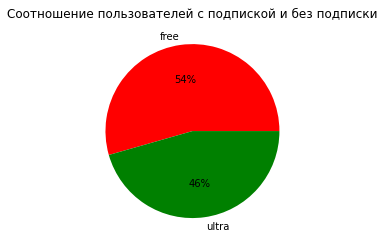

In [ ]:
subscription_type_count.plot(
    kind= 'pie', # Тип круговая диаграмма
    title='Соотношение пользователей с подпиской и без подписки', # Заголовок
    autopct= '%.0f%%', # Процентные метки
    ylabel='', # Подпись оси Y не должна отображаться
    colors= ['red', 'green'] # Цвета секторов
)

# Отобразим диаграмму
plt.show()

### 3.5 Гистограмма возрастов
Построим гистограмму возрастов `age` пользователей самокатов. Используем количество бинов, равное разности максимального и минимального значений возраста.


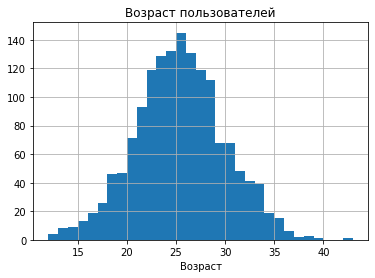

In [ ]:
# Определим количество бинов `n_bins` как разницу между максимальным и минимальным значениями в столбце `age`.
n_bins = df_users_go['age'].max() - df_users_go['age'].min()
# print(n_bins, df_users_go['age'].max(), df_users_go['age'].min())
df_users_go['age'].hist(bins=n_bins)

# Настраиваем внешний вид графика и выводим его на экран
plt.title('Возраст пользователей')
# Установим подпись оси X
plt.xlabel('Возраст')
plt.show()

### 3.6 Несовершеннолетние пользователи
Рассчитаем долю несовершеннолетних (возрастом менее 18 лет) пользователей самокатов.

In [16]:
users_under_18_ratio = int(100*df_users_go[df_users_go['age']<18].value_counts().sum() / 
                        df_users_go['age'].value_counts().sum())#.astype('int')
print(f'Доля несовершеннолетних пользователей самокатов составляет {users_under_18_ratio}%.')


Доля несовершеннолетних пользователей самокатов составляет 5%.


### 3.7 Характеристики длительности поездки
Длительность поездки является важной метрикой в работе сервиса проката самокатов. Если средняя длительность поездок будет слишком высокой, самокаты будут быстрее выходить из строя. Если слишком низкой, значит, клиентам что-то не нравится в сервисе.

С помощью описательной статистики изучим длительность поездок


In [ ]:
import numpy as np

# Расчитаем среднее значение и стандартное отклонение длительности поездки.
duration_mean = int(round(df_rides_go['duration'].mean()))
duration_std = int(np.std(df_rides_go['duration']))

# Рассчитаем 25-й и 75-й процентили длительности поездки.
duration_pct25 = int(np.percentile(df_rides_go['duration'], 25))
duration_pct75 = int(np.percentile(df_rides_go['duration'], 75))

# Выведем на экран результат
print(f'Средняя длительность поездки {duration_mean} минут со стандартным отклонением {duration_std}. Основная часть поездок занимает от {duration_pct25} до {duration_pct75} минут.')

Средняя длительность поездки 18 минут со стандартным отклонением 6. Основная часть поездок занимает от 14 до 22 минут.


---
## 4. Объединение данных

Объединим все три таблицы в один датафрейм.

### 4.1 Объединение таблицы пользователей и поездок
Объединим датафреймы с информацией о пользователях `df_users_go` и поездках `df_rides_go`. Полученный датафрейм назовём просто `df`. При объединении используем метод `merge()` по общей для двух таблиц колонке и тип объединения `left`.

In [18]:
df = df_users_go.merge(df_rides_go, on='user_id', how='left')
df

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,19,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,17,2021-11-27,11


### 4.2 Присоединение информации о подписках
Присоединим к полученному датафрейму `df` информацию о подписках из `df_subscriptions_go`, используя метод `merge()` по общей колонке.


In [19]:
df = df.merge(df_subscriptions_go, on='subscription_type', how='left') 
df

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,20,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,17,2021-11-27,11,8,50,0


### 4.3. Размеры объединённого датафрейма
Для финальной проверки выведем на экран первые пять строк датафрейма, а также количество строк и столбцов полученного датафрейма `df`. Этот этап позволит убедиться, что никакие записи не потерялись при объединении.

In [20]:
# Выводим первые строки датафрейма
display(df.head(5))

# Выводим количество строк и столбцов в объединённом датафрейме
n_rows, n_cols = df.shape
print(f'В полученном датафрейме {n_rows} строк и {n_cols} столбцов.')

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26,2021-08-28,8,6,0,199


В полученном датафрейме 18068 строк и 12 столбцов.


### 4.4 Отдельные датафреймы для пользователей с подпиской и без
Создадим два вспомогательных датафрейма на основе `df`: первый только для пользователей с подпиской `df_ultra` и второй только для пользователей без подписки `df_free`. 

In [21]:
df_ultra = df[df['subscription_type']=='ultra']
df_free = df[df['subscription_type']=='free']

# df_ultra
# df_free

### 4.5 Гистограмма длительности поездок для обоих групп
На одном графике построим гистограмму распределения длительности поездок `duration` для пользователей с подпиской и без.



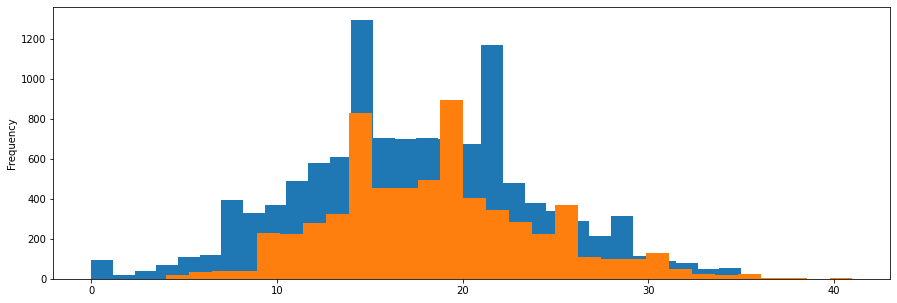

Средняя длительность поездки для пользователей без подписки 17 мин, а для пользователей с подпиской 19 мин


In [ ]:
# Гистограмма длительности поездки для пользователей с подпиской и без

# Установим размер графика
plt.figure(figsize=(15, 5))
 
df_free['duration'].plot( 
            kind='hist', # тип гравфика гистограмма
            bins=30, # зададим количество бинов
            label='free'
)

df_ultra['duration'].plot( 
            kind='hist',
            bins=30,
            label='ultra'
)

# Установим подпись оси X
plt.xlabel('Длительность поездки, мин.')
# Зададим заголовок графика
plt.title('Гистограмма распределения длительности поездок')
# Добавим легенду для различения категорий
plt.legend()
# Покажем график
plt.show()

# Расчет и вывод на экран средней длительности поездки для пользователей с подпиской и без
mean_duration_free = int(round(df_free['duration'].mean(), 2))
mean_duration_ultra = round(df_ultra['duration'].mean())
print(f'Средняя длительность поездки для пользователей без подписки {mean_duration_free} мин, а для пользователей с подпиской {mean_duration_ultra} мин')

---
## 5. Подсчёт выручки
Данные о количестве и длительности поездок объединены с ценами и тарифами, а значит, теперь есть всё необходимое, чтобы рассчитать важный для бизнеса показатель — выручку.

### 5.1 Данные сгруппированные по нужным колонкам
Сгруппируем данные по следующим столбцам: `user_id`, `name`, `subscription_type`, `month`. В итоговом датафрейме `df_gp` сохраним порядок агрегации изначальных столбцов и не будем использовать групповые индексы (опция `as_index=False`).


In [23]:
df_gp = df.groupby(['user_id', 'name', 'subscription_type', 'month'], as_index=False)
print(df_gp)

### 5.2 Подсчёт агрегированных метрик
Создадим новый датафрейм `df_agg`. В нём для каждой группы рассчитаем и добавим в датафрейм следующие агрегированные значения, используя метод `agg()`:
- `total_distance` — сумма значений в столбце `distance`.
- `total_duration` — сумма значений в столбце `duration`.
- `rides_count` — количество элементов в столбце `duration`.
- `subscription_type` — первое значение в группе для столбца `subscription_type`.
- `minute_price` — первое значение в группе для столбца `minute_price`.
- `start_ride_price` — первое значение в группе для столбца `start_ride_price`.
- `subscription_fee` — первое значение в группе для столбца `subscription_fee`.

<details>
<summary>Открыть подсказку</summary>
В этом задании удобнее всего сделать агрегацию с использованием кортежей.
</details>

In [24]:
df_agg = df_gp.agg( # Укажите подходящий инструмент здесь
    total_distance=('distance', 'sum'),
    total_duration= ('duration', 'sum'),
    rides_count= ('duration', 'count'),
    subscription_type= ('subscription_type', 'first'),
    minute_price= ('minute_price', 'first'),
    start_ride_price= ('start_ride_price', 'first'),
    subscription_fee= ('subscription_fee', 'first'),
)
df_agg

,user_id,name,month,total_distance,total_duration,rides_count,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,Кира,1,7027.511294,42,2,ultra,6,0,199
1,1,Кира,4,754.159807,6,1,ultra,6,0,199
2,1,Кира,8,6723.470560,45,2,ultra,6,0,199
3,1,Кира,10,5809.911100,32,2,ultra,6,0,199
4,1,Кира,11,7003.499363,53,3,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...
11326,1534,Альберт,6,3409.468534,24,2,free,8,50,0
11327,1534,Альберт,8,7622.453034,47,2,free,8,50,0
11328,1534,Альберт,9,4928.173852,23,1,free,8,50,0
11329,1534,Альберт,11,13350.015305,76,4,free,8,50,0


### 5.3 Функция для подсчёта выручки
Создадим функцию `calculate_monthly_revenue(row)` для расчёта месячной выручки по формуле:

`monthly_revenue` = `start_ride_price` * `rides_count` + `minute_price` * `total_duration` + `subscription_fee`

В качестве входных данных функция будет принимать одну строку `row` датафрейма. 

Здесь:
- `start_ride_price * rides_count` — выручка от начала каждой поездки.
- `minute_price * total_duration` — выручка за время использования.
- `subscription_fee` — фиксированная выручка от подписок.

In [25]:
def calculate_monthly_revenue(row):
    return  row['start_ride_price'] * row['rides_count'] + row['minute_price'] * row['total_duration'] + row['subscription_fee']


### 5.4 Создание столбца с месячной выручкой на пользователя
Создадим новый столбец с месячной выручкой на пользователя `monthly_revenue`. Для этого применим функцию `calculate_monthly_revenue(row)` к каждой строке агрегированного датафрейма `df_agg`.

In [26]:
df_agg['monthly_revenue'] = df_agg.apply(calculate_monthly_revenue, axis=1)#
df_agg

,user_id,name,month,total_distance,total_duration,rides_count,subscription_type,minute_price,start_ride_price,subscription_fee,monthly_revenue
0,1,Кира,1,7027.511294,42,2,ultra,6,0,199,451
1,1,Кира,4,754.159807,6,1,ultra,6,0,199,235
2,1,Кира,8,6723.470560,45,2,ultra,6,0,199,469
3,1,Кира,10,5809.911100,32,2,ultra,6,0,199,391
4,1,Кира,11,7003.499363,53,3,ultra,6,0,199,517
...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,Альберт,6,3409.468534,24,2,free,8,50,0,292
11327,1534,Альберт,8,7622.453034,47,2,free,8,50,0,476
11328,1534,Альберт,9,4928.173852,23,1,free,8,50,0,234
11329,1534,Альберт,11,13350.015305,76,4,free,8,50,0,808


### 5.5 Поиск пользователя с максимальной выручкой
Исследуем полученные значения выручки. Найдём пользователя с максимальной суммарной выручкой за весь период наблюдения и для него выведем на экран `user_id`, имя, месяц, количество поездок и выручку за каждый из месяцев.

In [27]:
df_max_revenue = df_agg.groupby(['user_id']).agg(total_revenue = ('monthly_revenue', 'sum')).sort_values(by='total_revenue', ascending=False).head(1).reset_index()#
# df_filtered = df_max_revenue.merge(df_agg[['user_id', 'name', 'month', 'rides_count', 'monthly_revenue']], on='user_id', how='left')
# df_filtered[['user_id', 'name', 'month', 'rides_count', 'monthly_revenue']]
df_max_revenue = df_max_revenue['user_id'].iloc[0]
# df_max_revenue
df_agg[['user_id', 'name', 'month', 'rides_count', 'monthly_revenue']][df_agg['user_id']==df_max_revenue]

,user_id,name,month,rides_count,monthly_revenue
8877,1236,Александр,1,2,228
8878,1236,Александр,2,3,614
8879,1236,Александр,3,5,762
8880,1236,Александр,4,1,202
8881,1236,Александр,5,3,574
8882,1236,Александр,6,1,282
8883,1236,Александр,7,1,290
8884,1236,Александр,8,2,452
8885,1236,Александр,9,1,122
8886,1236,Александр,10,3,430


---
## 6. Проверка гипотез

### 6.1 Импорт библиотеки SciPy
Импортируем библиотеку `scipy.stats` с сокращением `st`.

In [28]:
import scipy.stats as st

### 6.2 Вспомогательная функция для интерпретации результатов
Напишем вспомогательную функцию `print_stattest_results(p_value, alpha)`, которая будет интерпретировать результаты статистического теста на основе p-value и заданного уровня значимости (α-уровня). Функция должна решать, следует ли принять альтернативную гипотезу или сохранить нулевую гипотезу.

У функции два параметра:
- `p_value` (тип `float`) — значение p-value, полученное в результате выполнения статистического теста.
- `alpha` (тип `float`, необязательный, по умолчанию `alpha = 0.05`) — уровень значимости статистического теста, который используется как порог для принятия решения об отклонении нулевой гипотезы.

Если принимаем альтернативную гипотезу, выводится сообщение:
`'Полученное значение p_value=<Введённое значение p_value> меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.'`

Если мы не можем опровергнуть нулевую гипотезу, выводим сообщение: `'Полученное значение p_value=<Введённое значение p_value> больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.'`


In [ ]:
def print_stattest_results(p_value:float, alpha:float = 0.05):
    # Напишите код для функции здесь

    if p_value < alpha:
        print(f'Полученное значение p_value={p_value} меньше критического уровня alpha={alpha}. Принимаем альтернативную гипотезу.')
    else:
        print(f'Полученное значение p_value={p_value} больше критического уровня alpha={alpha}. Опровергнуть нулевую гипотезу нельзя.')
        
# Вызовим функцию для `p_value = 0.0001` и `p_value = 0.1`
print_stattest_results(p_value=0.0001)
print_stattest_results(p_value=0.1)

Полученное значение p_value=0.0001 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Полученное значение p_value=0.1 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


### 6.3 Длительность для пользователей с подпиской и без

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Сформулируем нулевую и альтернативную гипотезы:
- Нулевая гипотеза (Н0): Среднее время поездки у пользователей с подпиской и без подписки одинаковое.
- Альтернативная гипотеза (Н1): Среднее время поездки у пользователей с подпиской больше, чем у пользователей без подписки.


In [ ]:
# Используем неагрегированные данные
ultra_duration = df_ultra['duration']
free_duration = df_free['duration']

# Рассчитаем значение `p_value` для выбранной гипотезы, используя функции модуля `scipy.stats` и односторонний t-тест.
results = st.ttest_ind(ultra_duration, free_duration, alternative='greater' ) 
p_value =  results.pvalue

# Передадим функции `print_stattest_results` значение `p_value`
print_stattest_results(p_value)

# Рассчитаем среднюю длительность поездки для тарифов `ultra` и `free`
ultra_mean_duration = round(df_ultra['duration'].mean(), 2)
free_mean_duration =round(df_free['duration'].mean(), 2)

print(f'Средняя длительность поездки тарифа Ultra {ultra_mean_duration}')
print(f'Средняя длительность поездки тарифа Free {free_mean_duration}')

Полученное значение p_value=3.1600689435611813e-35 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя длительность поездки тарифа Ultra 18.55
Средняя длительность поездки тарифа Free 17.39


### 6.4 Длительность поездки: больше или меньше критического значения

Проанализируем ещё одну важную продуктовую гипотезу. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров?

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза (Н0): Средняя дистанция поездки у пользователей с подпиской равна 3130 м.

- Альтернативная гипотеза (Н1): Средняя дистанция поездки у пользователей с подпиской больше 3130 м.


In [ ]:
null_hypothesis = 3130

# Используем неагрегированные данные о каждой поездке пользователей с подпиской
ultra_distance = df_ultra['distance']

# Рассчитаем значение `p_value` для выбранной гипотезы, используя функции модуля `scipy.stats` и односторонний t-тест
results = st.ttest_1samp (ultra_distance , null_hypothesis, alternative = 'greater')
p_value = results.pvalue

# Передадим функции `print_stattest_results` значение `p_value`
print_stattest_results(p_value)

Полученное значение p_value=0.9195368847849785 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


### 6.5 Прибыль от пользователей с подпиской и без
Проверим гипотезу о том, что выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза (Н0): Средняя месячная выручка у пользователей с подпиской и без подписки одинаковая.
- Альтернативная гипотеза (Н1): Средняя месячная выручка у пользователей с подпиской выше, чем у пользователей без подписки.


In [ ]:
# Используем исходные данные о месячной выручке от каждого пользователя
revenue_ultra = df_agg['monthly_revenue'][ df_agg['subscription_type'] == 'ultra']
revenue_free = df_agg['monthly_revenue'][ df_agg['subscription_type'] == 'free']

# Рассчитаем значение `p_value` для выбранной гипотезы, используя функции модуля `scipy.stats` и односторонний t-тест.
results = st.ttest_ind(revenue_ultra, revenue_free, alternative = 'greater')
p_value = results.pvalue

# Передадим функции `print_stattest_results` значение `p_value`
print_stattest_results(p_value)

# Рассчитаем среднюю выручку для тарифов `ultra` и `free`
mean_revenue_ultra = round(revenue_ultra.mean())
mean_revenue_free = round(revenue_free.mean())

print(f'Средняя выручка подписчиков Ultra {mean_revenue_ultra} руб')
print(f'Средняя выручка подписчиков Free {mean_revenue_free} руб')

Полученное значение p_value=1.7274069878387966e-37 меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.
Средняя выручка подписчиков Ultra 358.5896757114494 руб
Средняя выручка подписчиков Free 321.75345689908795 руб


---
## 7. Распределения

В компании возникла идея предлагать дополнительную скидку подписчикам, совершающим длительные поездки продолжительностью более 30 минут. Необходимо оценить долю таких поездок.

Так как нас интересуют возможные значения для всей генеральной совокупности, то  учитывая, что у нас нет доступа ко всем данным о поездках, смоделируем длительность поездки с помощью нормального распределения, используя в качестве параметров выборочное среднее и стандартное отклонение из доступных данных о поездках.

### 7.1 Расчёт выборочного среднего и стандартного отклонения



In [ ]:
# Расчитаем среднюю длительность поездки
mu = df_ultra['duration'].mean()

# Вычисляем стандартное отклонение длительности `duration` 
sigma = df_ultra['duration'].std()

# Задаём целевое время. Эта переменная будет использоваться для последующего вычисления вероятности.
target_time = 30

# Делаем вывод
print(f'Средняя длительность поездки {round(mu, 1)}, стандартное отклонение {round(sigma)}.')

Средняя длительность поездки 18.5, стандартное отклонение 6.


### 7.2 Вычисление значения функции распределения в точке (CDF)
Если вычислить значение функции распределения в точке, это позволит узнать вероятность того, что случайная величина примет значение меньше заданного либо равное ему. Соответственно, для расчёта вероятности поездки более 30 минут, потребуется использовать CDF.


In [ ]:
# Используем функцию `norm()` из библиотеки SciPy для создания нормального распределения
duration_norm_dist  = st.norm(mu, sigma)

# Вычисляем вероятность того, что случайная величина будет меньше указанного значения или равна ему
prob = round(1 - duration_norm_dist.cdf(target_time), 3) # Используем CDF для нахождения накопленной вероятности

print(f'Вероятность поездки более 30 минут {prob}')

Вероятность поездки более 30 минут 0.02


### 7.3 Вероятность для интервала (CDF)
Коллеги посчитали, что процент пользователей, для которых будет показана скидка, недостаточно большой и вряд ли поможет в увеличении лояльности клиентов. Дополнительно проверим, какой процент пользователей совершает поездки в интервале от 20 до 30 минут. Возможно, именно для них стоит провести промоакцию?


In [ ]:
# Определяем границы временного интервала. Они равны 20 и 30 минут.
low = 20
high = 30

# Вычисляем вероятность попадания в интервал, используя кумулятивную функцию распределения (CDF) для объекта `duration_norm_dist`, 
# чтобы вычислить вероятность достижения верхней границы (`high`) и нижней границы (`low`).
prob_interval = round(duration_norm_dist.cdf(high) - duration_norm_dist.cdf(low), 3)

# Выводим результат
print(f'Вероятность того, что пользователь совершит поездку длительностью от {low} до {high} минут: {prob_interval}')

Вероятность того, что пользователь совершит поездку длительностью от 20 до 30 минут: 0.377


### 7.4 Определение критической дистанции поездок (PPF)
Длительные поездки могут негативно сказываться на сроке службы самоката. В связи с этим принято решение установить критическую дистанцию, превышение которой будет сопровождаться дополнительной платой. Для этого необходимо определить расстояние, которое превышается только в 10% поездок (90-й процентиль).

Задача — смоделировать распределение длительности поездок, предполагая, что оно подчиняется нормальному закону, и рассчитать критическую дистанцию, ниже которой находится 90% всех поездок.


In [ ]:
# Вычисляем среднее значение дистанции поездки для всех пользователей
mu = df['distance'].mean()

# Вычисляем стандартное отклонение дистанции поездки
sigma = df['distance'].std()

# Вероятность, для которой хотим найти значение (90% случаев)
target_prob = 0.90

# Создаём объект нормального распределения
distance_norm = st.norm(mu, sigma)

# Рассчитываем критическую дистанцию для заданного процентиля поездок
critical_distance = distance_norm.ppf(target_prob)

print(f'{100 * target_prob} % поездок имеют дистанцию ниже критического значения {critical_distance:.2f} М.')

90.0 % поездок имеют дистанцию ниже критического значения 4501.94 М.
